# Chapter 7: Ensemble Learning and Random Forests

## Voting classifiers

Use multiple models with different algorithms. Classification is then the majority voted class from all classifiers

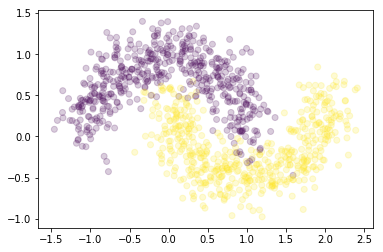

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

x, y = make_moons(n_samples=1000, noise = 0.2)
plt.scatter(x[:,0], x[:,1], c = y, alpha = 0.2)
plt.show()

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75)

/Users/mike/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [29]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.86
RandomForestClassifier 0.968
SVC 0.96
VotingClassifier 0.964


If all classifiers can predict_proba, can use voting = "soft" to get weighted answer. Usually better as gives additional weight to highly-confident votes.

In [30]:
soft_svm_clf = SVC(probability=True)

soft_voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('ssvc', soft_svm_clf)],
    voting = 'soft')
soft_voting_clf.fit(x_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf, soft_voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.86
RandomForestClassifier 0.968
SVC 0.96
VotingClassifier 0.96
VotingClassifier 0.964


## Bagging and Pasting

Instead of using different algorithms, as in voting, can train classifier on different random subsets of data.

* with replacement => bagging (bootstrap aggregation)
* w/o replacement => pasting

Uses mode for classifiers or average for regressors.

Generally have similar bias but lower variance than singlet models.

Scale very well as models can be trained and fit in parallel (across cores/servers/etc)

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 100, bootstrap = True, n_jobs = -1)
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.964

In [36]:
import numpy as np
def plotRegContour(clf, datx, daty):
    x0s = np.linspace(min(datx[:,0]), max(datx[:,0]), 100)
    x1s = np.linspace(min(datx[:,1]), max(datx[:,1]), 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    x = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(x).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2) 
def plotScatter(datx, daty):
    plt.scatter(datx[:,0], datx[:,1], c = daty, alpha = 0.25)
    



In [39]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

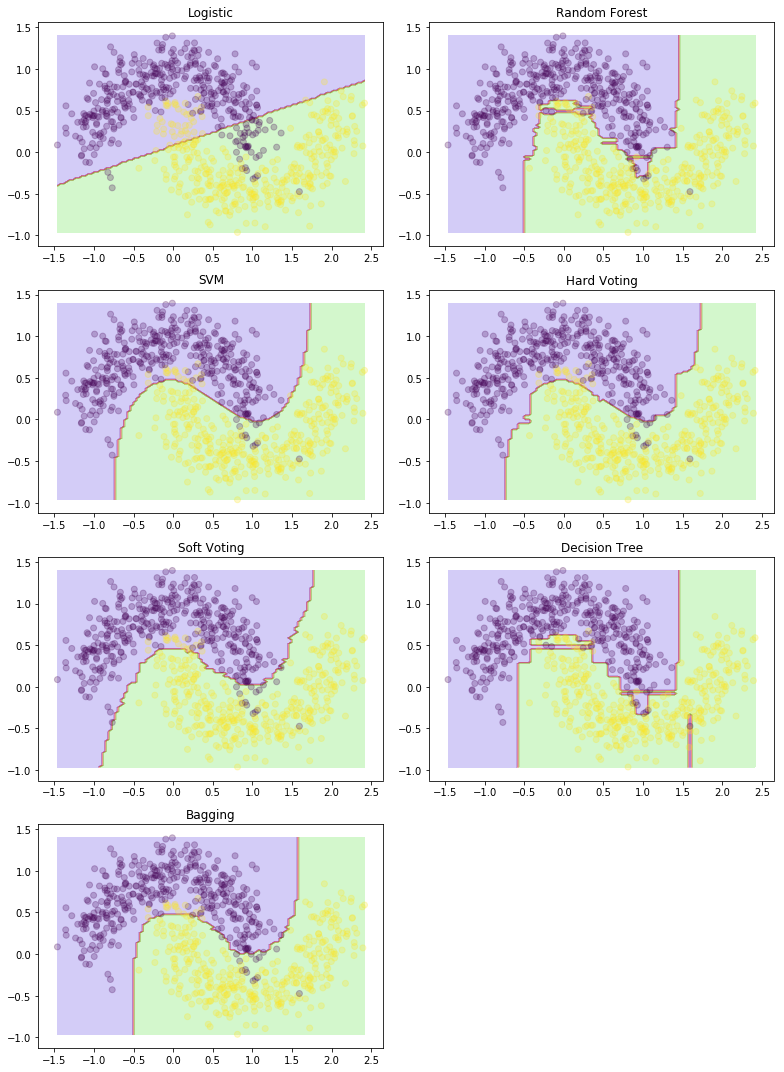

In [42]:
import math

plt.figure(figsize = (11, 15))
plt_labs = ("Logistic", "Random Forest", "SVM", "Hard Voting", "Soft Voting", "Decision Tree", "Bagging")
for i, clf in enumerate((log_clf, rnd_clf, svm_clf, voting_clf, soft_voting_clf, tree_clf, bag_clf)):
    plt.subplot(math.ceil(len(plt_labs) / 2), 2, i + 1)
    plotRegContour(clf, x_train, y_train)
    plotScatter(x_train, y_train)
    plt.title(plt_labs[i])
plt.tight_layout()
plt.show()

Since a bagging classifier misses some training instances (approx 63% per predictor). Can use these _out-of-bag_ instances for validation. set `oob_score=True` when creating BaggingClassifier.

In [43]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500, 
                            bootstrap=True, 
                            n_jobs=-1, 
                            oob_score=True)
bag_clf.fit(x_train, y_train)
bag_clf.oob_score_

0.9626666666666667

In [44]:
y_pred = bag_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.956

## Random Patches and Random Subspaces

Random Patches => randomly sample both instances and features (so each predictor is trained on a random subset of each)

Random subspaces => randomly sample features (not instances)

Each "trades a bit more bias for a lower variance" by generating more diverse predictors

## Random Forests

Ensemble of decision trees. Generally only a random subset of features is considered when splitting each node (generate more diverse predictors i.e. higher bias and lower variance)

ExtraTreesClassifier (Extremely Randomized Trees) also adds randomization to thresholds chosen at each node. Faster

Can use tree_clf.feature_importances_ to see which features are the most important.

## Boosting

Sequential training of weak classifiers (correcting for previous classifiers at each step), to result in a strong classifier

### Ada Boosting (Adaptive boosting)

Each successive classifier focues on the cases misclassified by the previous classifiers (i.e. the harder cases)

`AdaBoostClassifier` and `AdaBoostRegressor`

## Gradient Boosting

Like ada boosting, but instead of training successive classifiers on misclassified instances, trains the classifiers on the residual errors.

To prevent overfitting, use early stopping. Uses staged_predict()

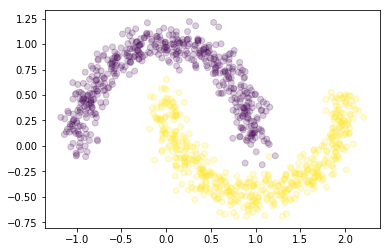

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_moons

x,y = make_moons(1000, noise = 0.1)

plt.scatter(x[:,0], x[:,1], c = y, alpha = 0.2)
plt.show()


In [47]:
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_val, y_train, y_val = train_test_split(x, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=119, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

Or terminate early using warm-start

In [48]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

## Stacking

Like Boosting but uses a training model to generate predictions from multiple input models